# **Importing libraries**

In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [1]:
#Import tensorflow and keras modules
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle

In [2]:
#Save Model Function
def save_m(file, model):
    if not os.path.exists(file):
        os.makedirs(file)

    model.save_weights(file+'/model.h5')
    model_json = model.to_json()
    with open(file + "/model.json", "w") as json_file:
        json_file.write(model_json)

#Save History Function
def save_h(file, history):
    if not os.path.exists(file):
        os.makedirs(file)

    with open(file + '/' + 'model.history', 'wb') as file_pi:
        pickle.dump(history, file_pi)

#Load History Function
def load_h(file):
    with open(file + '/' + 'model.history', 'rb') as file_pi:
        his = pickle.load(file_pi)
    return his

# **Loading and Prepraring Data**

In [3]:
#Define Constants
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4
EPOCHS = 30
LEARNING_RATE = 0.0001

#Data paths
TRAIN_DATA_PATH = 'ds/train/'
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

#Model path
TEACHER_MODEL_PATH = 'models/Teacher_Models/'

In [ ]:
#Create Generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

#Set Generator
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_PATH, 
                                                    target_size=IMAGE_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(VAL_DATA_PATH, 
                                                        target_size=IMAGE_SIZE, 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(TEST_DATA_PATH, 
                                                  target_size=IMAGE_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical')

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)
num_classes= len(train_generator.class_indices)

print('NUMBER OF TRAIN SAMPLES:', nb_train_samples)
print('NUMBER OF VALIDATION SAMPLES:',nb_validation_samples)
print('NUMBER OF TEST SAMPLES:',nb_test_samples)
print('TOTAL CLASSES:', num_classes)

Found 1990 images belonging to 199 classes.
Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.
NUMBER OF TRAIN SAMPLES: 1990
NUMBER OF VALIDATION SAMPLES: 1194
NUMBER OF TEST SAMPLES: 796
TOTAL CLASSES: 199


# **Training**

**Using InceptionResNetV2**

In [ ]:
#Load pretrained model
from tensorflow.keras.applications import InceptionResNetV2
transfer = InceptionResNetV2(include_top = False, weights = 'imagenet',input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

model = tf.keras.Sequential([
    transfer,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(199)
])
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 199)               305863    
Total params: 54,642,599
Trainable params: 54,582,055
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
#Start Training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.000001)

callbacks = [reduce_lr]

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss = CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
        train_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        steps_per_epoch = nb_train_samples  // BATCH_SIZE,
        validation_steps = nb_validation_samples // BATCH_SIZE,
        validation_data = validation_generator
)

Epoch 1/30
497/497 [==============================] - 106s 188ms/step - loss: 5.4007 - accuracy: 0.0083 - val_loss: 4.8702 - val_accuracy: 0.0965
Epoch 2/30
497/497 [==============================] - 90s 181ms/step - loss: 4.2716 - accuracy: 0.1533 - val_loss: 2.3522 - val_accuracy: 0.4522
Epoch 3/30
497/497 [==============================] - 90s 181ms/step - loss: 2.0356 - accuracy: 0.6644 - val_loss: 1.0889 - val_accuracy: 0.7173

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/30
497/497 [==============================] - 90s 181ms/step - loss: 0.7370 - accuracy: 0.9310 - val_loss: 0.6382 - val_accuracy: 0.8255
Epoch 5/30
497/497 [==============================] - 89s 180ms/step - loss: 0.3448 - accuracy: 0.9762 - val_loss: 0.5980 - val_accuracy: 0.8532

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 6/30
497/497 [==============================] - 90s 181ms/step - loss: 0.1820 - accuracy: 0.9968 - val_los

In [ ]:
#testing
acc = model.evaluate(test_generator)

199/199 [==============================] - 11s 55ms/step - loss: 0.5552 - accuracy: 0.8656


In [ ]:
print("MODEL AND HISTORY SAVED")
#save model
save_m(TEACHER_MODEL_PATH + 'InceptionResNetV2', model)
#save history
save_h(TEACHER_MODEL_PATH + 'InceptionResNetV2', history.history)

MODEL AND HISTORY SAVED


# **Training Visualization**

In [6]:
#VISUAL CUSTOMIZER
distiller_history = load_h(TEACHER_MODEL_PATH + 'InceptionResNetV2')

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10
fontsize = 7

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for the ease of your evaluation")

You may change the values if needed for the ease of your evaluation


**Accuracy Curve**

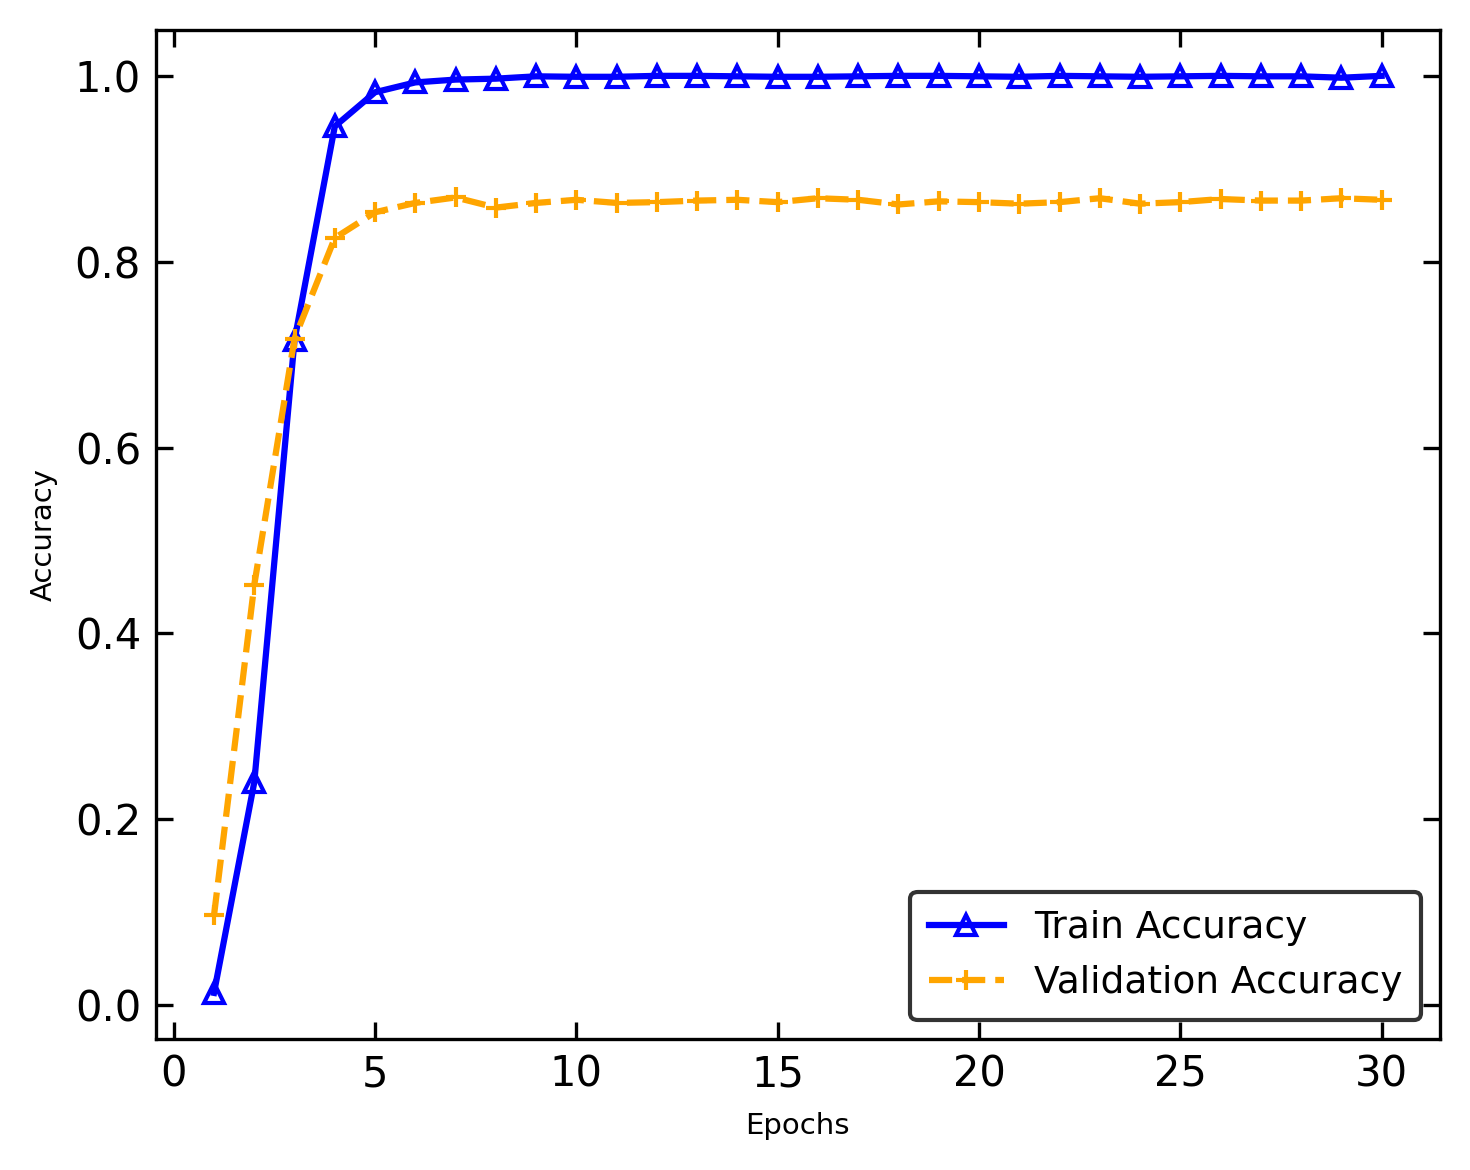

In [7]:
#PRINTS THE ACCURACY GROWTH
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in") 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), distiller_history["accuracy"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), distiller_history["val_accuracy"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Accuracy", fontsize=fontsize, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()

**Loss Curve**

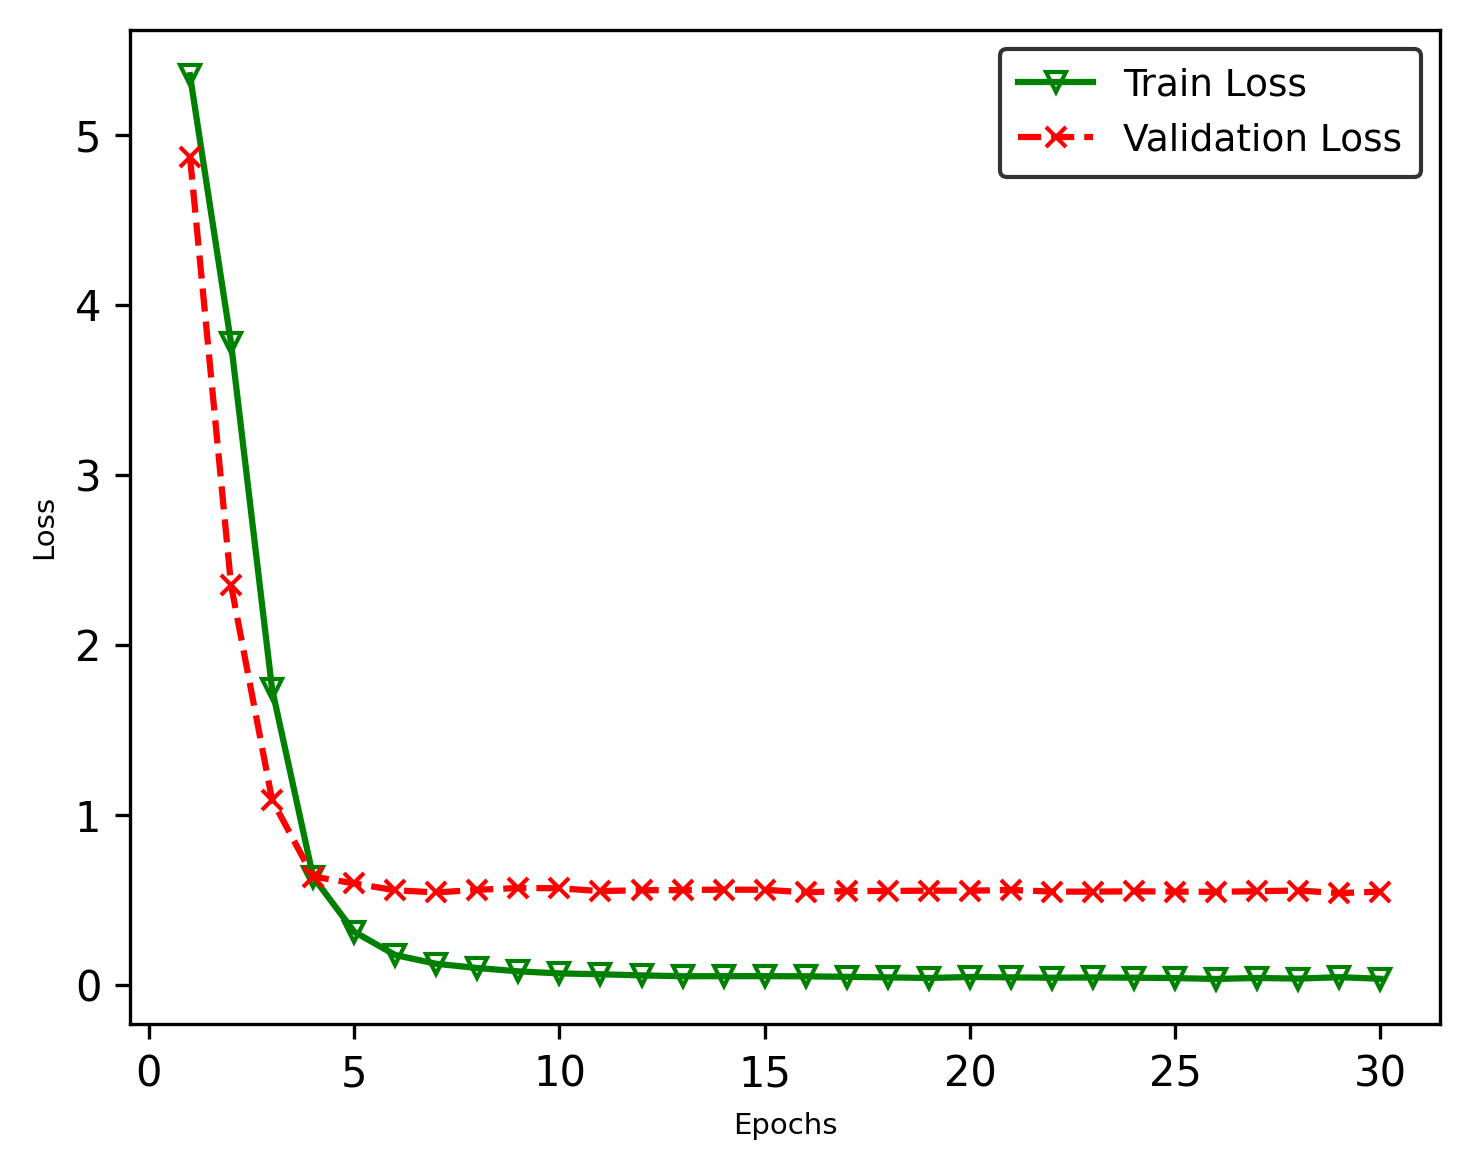

In [8]:
#PRINTS THE DECREASE OF LOSS
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300)
plt.plot(np.arange(1, N+1), distiller_history["loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), distiller_history["val_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v, label="Validation Loss")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Loss", fontsize=fontsize, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()